# Multivariate timeseries segmentation using the `tGLAD` framework

In [1]:
# import necessary libraies
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from utils.read_pamap import load_subjects
from uGLAD.uglad_utils import ggm as ggm
from main import (
    get_partial_correlation_from_precision,
    get_all_edges,
    distance_graph,
    get_label,
)
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json

from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

/home/kir0ul/miniforge3/envs/tGLAD


In [2]:
from get_data import data2df, DATAPATH_ROOT, get_ground_truth

In [3]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = [
    "Fira Sans",
    "Computer Modern Sans Serif",
    "DejaVu Sans",
    "Verdana",
    "Arial",
    "Helvetica",
]

## Get data

In [4]:
# reading data
# subject_data = "data/PAMAP2_Dataset/Protocol/subject101.dat"
# subject_data = "data/PAMAP2_Dataset/Optional/subject101.dat"
# data = load_subjects(subject_data)

In [5]:
# label = "activity_id"
# start_part, end_part = 76000, 179000
# column_list = [
#     "hand_3D_acceleration_16_x",
#     "hand_3D_acceleration_16_z",
#     "ankle_3D_gyroscope_x",
# ]
# column_list.append(label)
# modified_df = data[column_list][start_part:end_part]
# modified_df = modified_df.ffill()
# modified_df = modified_df.bfill()

df = data2df(filenum=0, timestamps=False)
df

,x,y,z
0,0.425767,0.243364,0.976381
1,0.425373,0.243382,0.976542
2,0.425282,0.243515,0.976639
3,0.425282,0.243515,0.976639
4,0.425350,0.243331,0.976105
...,...,...,...
7333,0.662908,0.221483,1.031193
7334,0.662635,0.221682,1.031233
7335,0.662784,0.222090,1.030785
7336,0.662740,0.221329,1.030948


In [6]:
class_vect = get_ground_truth(filenum=0)
class_vect

array([1., 1., 1., ..., 5., 5., 5.], shape=(7338,))

In [7]:
df["ID"] = class_vect
df

,x,y,z,ID
0,0.425767,0.243364,0.976381,1.0
1,0.425373,0.243382,0.976542,1.0
2,0.425282,0.243515,0.976639,1.0
3,0.425282,0.243515,0.976639,1.0
4,0.425350,0.243331,0.976105,1.0
...,...,...,...,...
7333,0.662908,0.221483,1.031193,5.0
7334,0.662635,0.221682,1.031233,5.0
7335,0.662784,0.222090,1.030785,5.0
7336,0.662740,0.221329,1.030948,5.0


In [8]:
extended_win = 1000
batch_size = 20
stride_length = 100

In [9]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
for col in df.columns:
    # Add traces
    fig.add_trace(go.Scatter(y=df[col].values, name=col, mode="lines"))
fig.update_layout(
    title="PFCS data",
    font=dict(
        size=18,
    ),
)
fig.update_xaxes(title_text="Index")
fig.show()

## Correlation matrix

torch.Size([1, 60, 60])


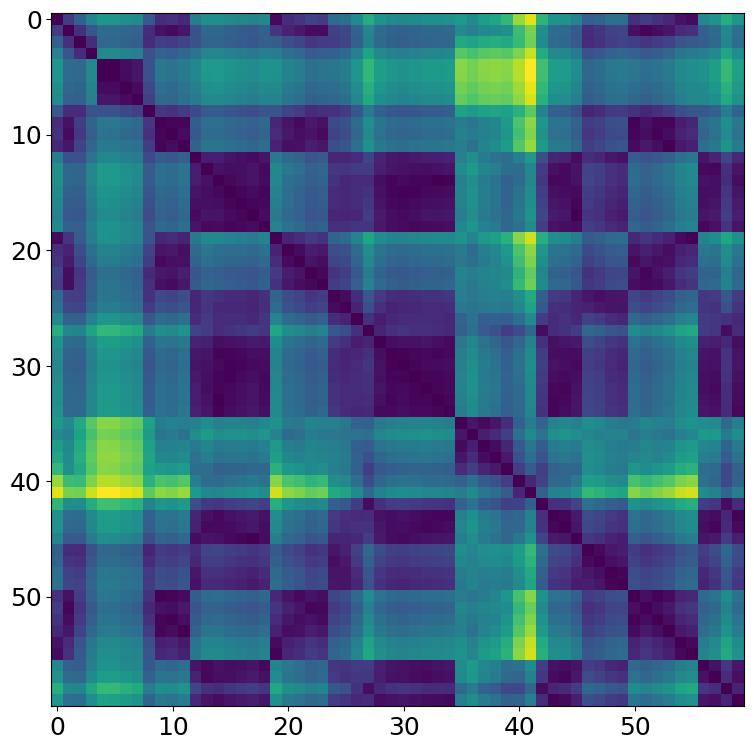

In [10]:
with open("result/table task/matrix_res_20_1000.npy", "rb") as f:
    matrix_res = np.load(f)
input_matrix_res = torch.from_numpy(matrix_res)
m = nn.AvgPool2d(1, stride=1)
input_matrix_res = input_matrix_res.view(
    1, input_matrix_res.size()[0], input_matrix_res.size()[1]
)
output = m(input_matrix_res)
print(output.size())
output = output.view(output.size()[1], -1)

plt.figure(figsize=(9, 9))
plt.imshow(output)
tick_labels = np.arange(0, len(df), extended_win)
# plt.xticks(np.arange(0,len(output), stride_length) , tick_labels, fontsize=14)
# plt.yticks(np.arange(0,len(output), stride_length) , tick_labels, fontsize=14)
plt.show()

## Segmentation results

In [11]:
with open("result/table task/uglad_precision_lst_20_1000.npy", "rb") as f:
    uglad_precision_lst = np.load(f)

g_correlation_map = {}

for i in tqdm(range(len(uglad_precision_lst))):
    g_correlation = get_partial_correlation_from_precision(
        uglad_precision_lst[i], df.columns
    )
    g_correlation_map[len(g_correlation_map)] = g_correlation

  0%|          | 0/60 [00:00<?, ?it/s]

In [12]:
class_vect = get_ground_truth(filenum=0)
gt = (class_vect > 0) * 1.0
# gt = (modified_df["activity_id"].values > 0) * 1.0
all_edges = get_all_edges(df.columns)
dg_corr = [
    distance_graph(g_correlation_map[i], g_correlation_map[i - 1], all_edges)
    for i in range(1, len(g_correlation_map))
]
scaled_dg_corr = np.array(dg_corr).repeat(stride_length, axis=0)
ddg_corr = np.array(
    [
        abs(scaled_dg_corr[i] - scaled_dg_corr[i - 1])
        for i in range(1, len(scaled_dg_corr))
    ]
)
thresh_ddg_corr = (np.array(ddg_corr) > 0.5) * np.array(ddg_corr)

In [13]:
labels = get_label(extended_win, thresh_ddg_corr)
print(
    f"batch_size:{batch_size}, window_size:{extended_win}, accuracy:{accuracy_score(gt[: len(labels)], labels)}"
)

batch_size:20, window_size:1000, accuracy:0.08492964909306662


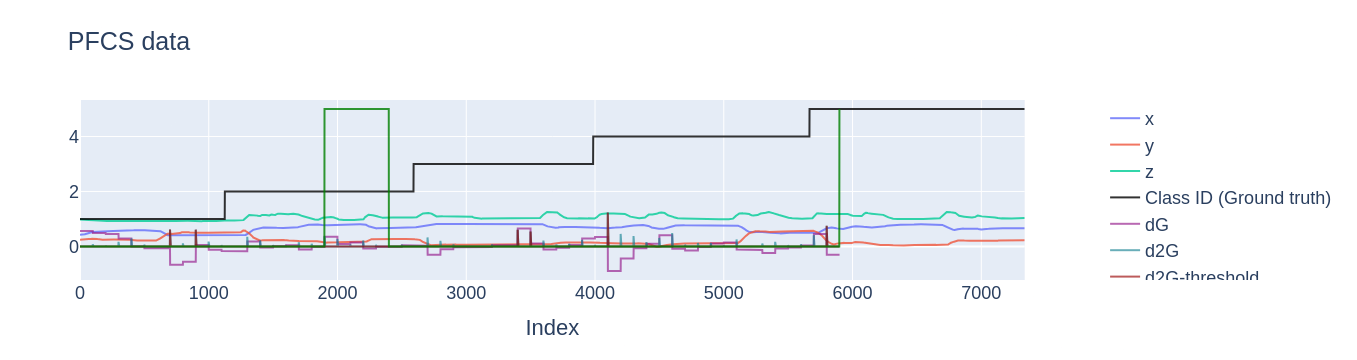

In [14]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
for col in df.columns:
    # Add traces
    if col == "ID":
        fig.add_trace(
            go.Scatter(
                y=df["ID"].values,
                name="Class ID (Ground truth)",
                mode="lines",
                line_color="#000000",
            )
        )
    else:
        fig.add_trace(go.Scatter(y=df[col].values, name=col, mode="lines"))

fig.add_trace(
    go.Scatter(
        y=scaled_dg_corr,
        name="dG",
        mode="lines",
        marker_color="rgba(146, 21, 136, 0.8)",
    )
)
fig.add_trace(
    go.Scatter(
        y=ddg_corr, name="d2G", mode="lines", marker_color="rgba(21, 130, 146, 0.8)"
    )
)
fig.add_trace(
    go.Scatter(
        y=thresh_ddg_corr,
        name="d2G-threshold",
        mode="lines",
        marker_color="rgba(152, 0, 0, .8)",
    )
)
fig.add_trace(
    go.Scatter(
        y=5 * labels, name="tGLAD (Prediction)", mode="lines", line_color="#008000"
    )
)

fig.update_layout(
    title="PFCS data",
    font=dict(
        size=18,
    ),
)
fig.update_traces(opacity=0.8)
fig.update_xaxes(title_text="Index")
fig.show()

In [15]:
# with open(
#     "data/varied_window_batch_accuracy_res/variation_window_batch_all.json", "r"
# ) as f:
#     window_batch_accuracy = json.load(f)
# df = pd.DataFrame(data=window_batch_accuracy)

# df = df.sort_values("batch_size")
# # create a line plot trace for each batch size
# traces = []
# batch_sizes = df["batch_size"].unique()
# colors = [
#     "Viridis",
#     "Greys",
#     "YlOrRd",
#     "Blues",
#     "Reds",
#     "Greys",
#     "YlOrRd",
#     "Blues",
#     "Reds",
# ]  # add more colors as needed
# for i, batch_size in enumerate(batch_sizes):
#     df_batch = df[df["batch_size"] == batch_size]
#     trace = go.Scatter(
#         x=df_batch["window_size"],
#         y=df_batch["accuracy"],
#         mode="markers",
#         marker=dict(size=25, color=i, colorscale=colors[i], showscale=False),
#         name=f"M={batch_size}",
#     )
#     traces.append(trace)

# # define the layout of the plot

# layout = go.Layout(
#     title="Effect of varying window size and batch size",
#     title_y=0.99,
#     title_x=0.5,
#     xaxis=dict(
#         title="Window Size",
#         linecolor="black",
#         showgrid=False,
#         ticks="outside",
#         tickvals=[500, 1000, 750, 1250, 1500, 1750, 2000],
#     ),
#     yaxis=dict(
#         title="Accuracy",
#         linecolor="black",
#         showgrid=False,
#         ticks="outside",
#         ticklen=10,
#         tickwidth=2,
#     ),
#     legend=dict(
#         traceorder="normal",
#         bgcolor="rgba(0,0,0,0)",
#         x=0,
#         y=1.08,
#         orientation="h",
#         font=dict(size=23),
#     ),
#     plot_bgcolor="white",
#     paper_bgcolor="white",
#     width=1200,  # set the width to 800 pixels
#     height=800,
#     font=dict(
#         size=30,
#     ),
# )

# fig = go.Figure(data=traces, layout=layout)
# fig.show()